## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

In [1]:
# !pip install http://download.pytorch.org/whl/cu90/torch-0.4.0-cp36-cp36m-linux_x86_64.whl 
# !pip install torchvision
# !pip install --upgrade tensorflow-gpu
# !pip install unidecode inflect librosa tensorboardX

#### Import libraries and setup matplotlib

In [2]:
import matplotlib
import matplotlib.pylab as plt
import IPython.display as ipd
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence

%matplotlib inline

/home/qianhuang/tacotron2/plotting_utils.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/qianhuang/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/qianhuang/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/qianhuang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/qianhuang/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/qianhuang/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loo

In [3]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [4]:
hparams = create_hparams("distributed_run=False,mask_padding=False")
hparams.sampling_rate = 22050
hparams.filter_length = 1024
hparams.hop_length = 256
hparams.win_length = 1024

INFO:tensorflow:Parsing command line hparams: distributed_run=False,mask_padding=False


#### Load model from checkpoint

In [5]:
checkpoint_path = "/home/qianhuang/tacotron2/outdir_thchs/checkpoint_3000"
# checkpoint_path = "/home/qianhuang/tacotron2/outdir_lr1e-4/checkpoint_30000"
model = load_model(hparams)
try:
    model = model.module
except:
    pass
model.load_state_dict({k.replace('module.',''):v for k,v in torch.load(checkpoint_path)['state_dict'].items()})
# model.cpu()
print("evaluating...")
_ = model.eval()
print("done")

/home/qianhuang/tacotron2/layers.py:35: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  self.conv.weight, gain=torch.nn.init.calculate_gain(w_init_gain))
/home/qianhuang/tacotron2/layers.py:15: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  gain=torch.nn.init.calculate_gain(w_init_gain))


evaluating...
done


#### Prepare text input

In [44]:
text = "lv4   shi4   yang2 chun1   yan1   jing3   da4 kuai4   wen2 zhang1   de5   di3 se4   si4 yue4   de5   lin2   luan2   geng4 shi4   lv4   de2   xian1 huo2   xiu4 mei4   shi1 yi4   ang4 ran2"
sequence = np.array(text_to_sequence(text, ['basic_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### label mel

In [45]:
import hparams
import numpy as np
from data_utils import TextMelLoader

In [46]:
hparams = create_hparams()
trainset = TextMelLoader(hparams.training_files, hparams)
label_mel = trainset.get_mel('/datasets/THCHS30/A2/wavs/A2_0.wav')
label_mel_tensor = torch.tensor(label_mel).unsqueeze(0)

#### Decode text input and plot results

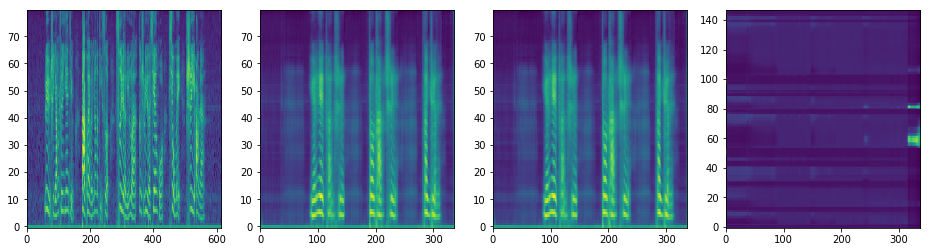

In [47]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((label_mel, mel_outputs.data.cpu().numpy()[0],
           mel_outputs_postnet.data.cpu().numpy()[0],
           alignments.data.cpu().numpy()[0].T))

#### Load TacotronSTFT and convert mel-spectrogram to spectrogram

In [48]:
taco_stft = TacotronSTFT(
    hparams.filter_length, hparams.hop_length, hparams.win_length, 
    sampling_rate=hparams.sampling_rate)
mel_decompress = taco_stft.spectral_de_normalize(mel_outputs_postnet)
mel_decompress = mel_decompress.transpose(1, 2).data.cpu()
spec_from_mel_scaling = 1000
spec_from_mel = torch.mm(mel_decompress[0], taco_stft.mel_basis)
spec_from_mel = spec_from_mel.transpose(0, 1).unsqueeze(0)
spec_from_mel = spec_from_mel * spec_from_mel_scaling

#### Synthesize audio from spectrogram using the Griffin-Lim algorithm

In [49]:
waveform = griffin_lim(torch.autograd.Variable(spec_from_mel[:, :, :-1]), 
                       taco_stft.stft_fn, 60)

In [50]:
ipd.Audio(waveform[0].data.cpu().numpy(), rate=hparams.sampling_rate) 

#### transform tacotron mel to wavenet mel

In [21]:
import librosa.core.time_frequency as t

def _normalize(S):
    return np.clip((S + 100) / 100, 0, 1)


def _denormalize(S):
    return (np.clip(S, 0, 1) * 100) - 100

def _amp_to_db(x):
    min_level = np.exp(-100 / 20 * np.log(10))
    return 20 * np.log10(np.maximum(min_level, x))


In [22]:
mel_np = mel_outputs_postnet.data.cpu().numpy()[0].T

axis = np.linspace(t.hz_to_mel(125), t.hz_to_mel(7600),80)
trimed = np.zeros(mel_np.shape)
for i in range(mel_np.shape[0]):
    for j in range(mel_np.shape[1]):
        trimed[i][j] = mel_np[i][(int)(axis[j]*80/t.hz_to_mel(11025))]
    

In [23]:
wavenet_mel = _normalize(_amp_to_db(np.exp(trimed) ) - 20) 

In [24]:
# np.save('/home/qianhuang/30000iter_droppedlr_ex.npy',mel_np)
# np.save('/home/qianhuang/30000iter_droppedlr_ex.npy',wavenet_mel)
# np.save('/home/qianhuang/24500iter_ex.npy',mel_np)
np.save('/home/qianhuang/24500iter_ex.npy',wavenet_mel)

